In [2]:
import pandas as pd
import numpy as np
import datetime
import tushare as ts 
import matplotlib.pyplot as plt  
from scipy.optimize import minimize

In [3]:
#根据股票代码列表获取股票价格
def get_prices(stock_list,start_date,end_date,price_type):
    price_df = pd.DataFrame()
    pro = ts.pro_api('8880894ba35f78a3f6030974566db30a32c88e8631e33f363cee6f8a')
    
    #逐个获取列表中的股票价格
    for stock_code in stock_list:
        all_price=pro.daily(ts_code=stock_code,start_date=start_date,end_date=end_date)
       
        price=all_price.loc[:,[price_type]]
        price.columns = [stock_code]
       
        if price_df.empty:
            price_df=price
        else:
            price_df=pd.merge(price_df,price,left_index = True,right_index = True,how = 'outer')
    return price_df

In [4]:
#根据投资组合中股票的权重、历史价格和无风险利率计算投资组合的年收益、风险、夏普比率
def get_return_risk(port_i_weights_array,his_prices_df,risk_free,trade_days=250):
    #计算各成分股的历史日对数收益率
    his_day_returns = np.log(his_prices_df / his_prices_df.shift(-1))
    
    #组合的日收益率用成分股的日收益率乘权重再相加得到
    #日收益率均值进行年化
    port_i_year_return = np.sum(his_day_returns.mean()*trade_days*port_i_weights_array)
    
    #组合的日方差根据日收益率的协方差矩阵和权重得到
    #日方差均值进行年化
    port_i_year_sigma = np.sqrt(np.dot(port_i_weights_array, np.dot(his_day_returns.cov()*trade_days, 
                                                                    port_i_weights_array.T)))
    
    #计算各组合的夏普比率
    port_i_year_sr=(port_i_year_return-risk_free)/port_i_year_sigma
    
    return port_i_year_return,port_i_year_sigma,port_i_year_sr

In [5]:
#根据单个投资，投资组合数量来生成投资组合
def montecarlo_portfolios(stock_list,number,start_date,end_date,risk_free,trade_days=250):
    port_weights_list = []
    port_returns_list = []
    port_sigmas_list = []
    port_sr_list = []
    
    #成分股每日收盘价格列表
    his_prices_df =get_prices(stock_list,start_date,end_date,'close') 
    
    #蒙特卡洛模拟，产生number个投资组合
    for i in range(number):
        #随机生成每个投资组合中每个资产的权重
        weights_i_array = np.random.random(len(stock_list))
        weights_i_array /=np.sum(weights_i_array)
        #计算本次组合的收益和风险
        port_i_year_return,port_i_year_sigma,port_i_year_sr = get_return_risk(weights_i_array,
                                                                              his_prices_df,risk_free)       
        #本次投资组合的权重信息加入权重列表
        port_weights_list.append(weights_i_array)
        #本次投资组合的收益率信息加入收益率列表
        port_returns_list.append(port_i_year_return)
        #本次投资组合的方差信息加入标准差列表
        port_sigmas_list.append(port_i_year_sigma)
        #本次投资组合的夏普比率加入夏普比率列表
        port_sr_list.append(port_i_year_sr)
        
    #列表转为ndarray
    port_weights_array = np.array(port_weights_list)
    port_returns_array = np.array(port_returns_list)
    port_sigmas_array = np.array(port_sigmas_list)
    port_sr_array = np.array(port_sr_list)        
    #print(port_weights_array.shape,port_returns_array.shape,port_sigmas_array.shape,port_sr_array.shape)
    return port_weights_array,port_returns_array,port_sigmas_array,port_sr_array

In [6]:
#RF = ts.shibor_data('2018')['1Y'].mean()
RF = 0.0355
START_DATE='20160101'
#END_DATE=datetime.datetime.now().strftime('%Y%m%d')
END_DATE='20171231'

#上证50成分股列表
SH50_CODE_LIST = ['603993.sh','601989.sh','601988.sh','601881.sh','601878.sh','601857.sh','601818.sh',
              '601800.sh','601766.sh','601688.sh','601668.sh','601628.sh','601601.sh','601398.sh',
              '601390.sh','601360.sh','601336.sh','601328.sh','601318.sh','601288.sh','601229.sh',
              '601211.sh','601186.sh','601169.sh','601166.sh','601088.sh','601006.sh','600999.sh',
              '600958.sh','600887.sh','600703.sh','600690.sh','600606.sh','600585.sh','600547.sh',
              '600519.sh','600340.sh','600309.sh','600276.sh','600111.sh','600104.sh','600050.sh',
              '600048.sh','600036.sh','600030.sh','600029.sh','600028.sh','600019.sh','600016.sh',
              '600000.sh']


#股票数量
STOCK_NUMS = len(SH50_CODE_LIST)

#用蒙特卡洛模拟生成投资组合的个数
PORT_NUM = 10000

In [7]:
#获取上证50成分股16、17两年的每日收盘价
SH50_PRICE_DF = get_prices(SH50_CODE_LIST,START_DATE,END_DATE,'close')

#PORT_WEIGHTS,PORT_RETURNS,PORT_SIGMAS,PORT_SR分别为各投资组合的权重信息，收益率，标准差，夏普比率
PORT_WEIGHTS,PORT_RETURNS,PORT_SIGMAS,PORT_SR = montecarlo_portfolios(SH50_CODE_LIST,
                                                                      PORT_NUM,START_DATE,END_DATE,RF)

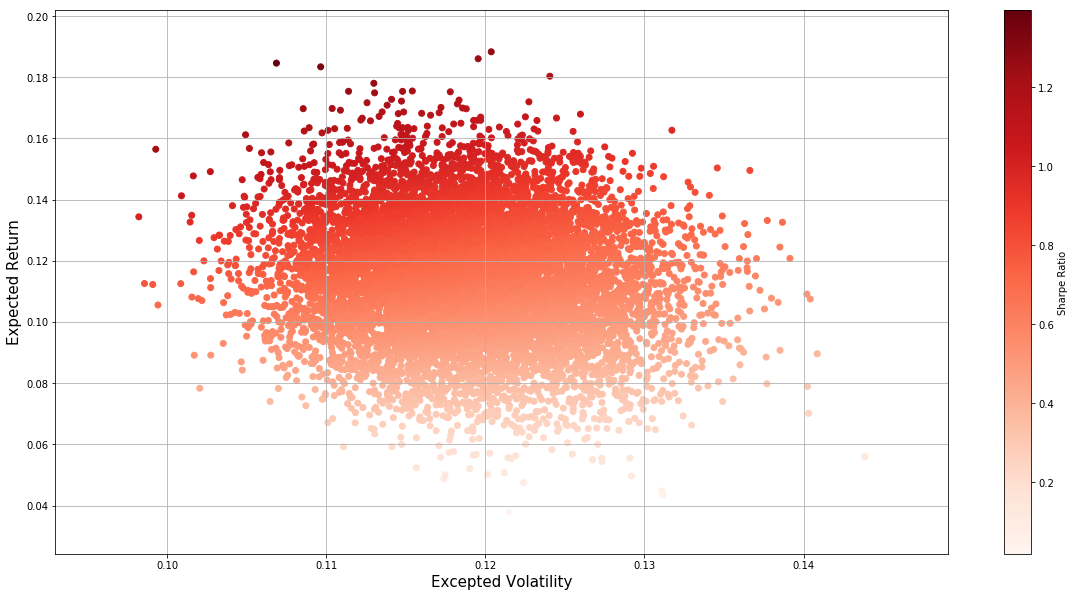

In [8]:
plt.figure(figsize = (20,10))
#用散点图绘制，越红Sharpe Ratio越大
plt.scatter(PORT_SIGMAS, PORT_RETURNS, c=PORT_SR, marker = 'o', cmap='Reds')
plt.grid(True)
plt.xlabel('Excepted Volatility',fontsize=15)
plt.ylabel('Expected Return',fontsize=15)
plt.colorbar(label = 'Sharpe Ratio')
plt.show()

In [9]:
#求最大夏普比率的点
#最小化的目标函数用夏普指数的负值
def min_negtive_sharpe(init_weights_array):
    return -get_return_risk(init_weights_array,SH50_PRICE_DF,RF)[2]

#求最小风险的点
#最小化的目标函数用标准差
def min_sigma(init_weights_array):
    return get_return_risk(init_weights_array,SH50_PRICE_DF,RF)[1]

In [10]:
#约束是所有参数(权重)的总和为1。用minimize函数的约定表达如下
CONS = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
#将参数值(权重)限制在0.001和1之间,保证前沿上的点包含了所有资产
BNDS = tuple((0.001,1.0) for x in range(STOCK_NUMS))

In [11]:
#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
#MAX_SHARP['x']是最大夏普比率的组合中各股票的权重
MAX_SHARP = minimize(min_negtive_sharpe, STOCK_NUMS*[1./STOCK_NUMS,], method = 'SLSQP', 
                         bounds = BNDS, constraints = CONS)

#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
#MIN_SIGMA['x']是最小标准差的组合中各股票的权重
MIN_SIGMA = minimize(min_sigma, STOCK_NUMS*[1./STOCK_NUMS,],method = 'SLSQP', 
                         bounds = BNDS, constraints = CONS)

In [12]:
#计算有效前沿上的投资组合
def get_efficient_frontier(price_df,rf):
    stock_num = price_df.shape[1]
    frontier_returns_array = np.linspace(0.0,0.5,50)
    frontier_sigma_array = []

    #遍历每个收益率，去寻找风险最小的投资组合
    for ret in frontier_returns_array:
        #约束条件：1.收益率等于ret；2.各权重和等于1
        frontier_cons = ({'type':'eq','fun':lambda x:get_return_risk(x,price_df,rf)[0]-ret},
                         {'type':'eq','fun':lambda x:np.sum(x)-1})
        frontier_point = minimize(min_sigma, stock_num*[1./stock_num,],method = 'SLSQP', 
                                      bounds = BNDS, constraints = frontier_cons)
        #print(frontier_point['x'])
        frontier_sigma_array.append(frontier_point['fun'])
        
    frontier_sigma_array = np.array(frontier_sigma_array)
    return frontier_returns_array,frontier_sigma_array

In [13]:
FRONTIER_RETURNS_ARRAY,FRONTIER_SIGMA_ARRAY = get_efficient_frontier(SH50_PRICE_DF,RF)

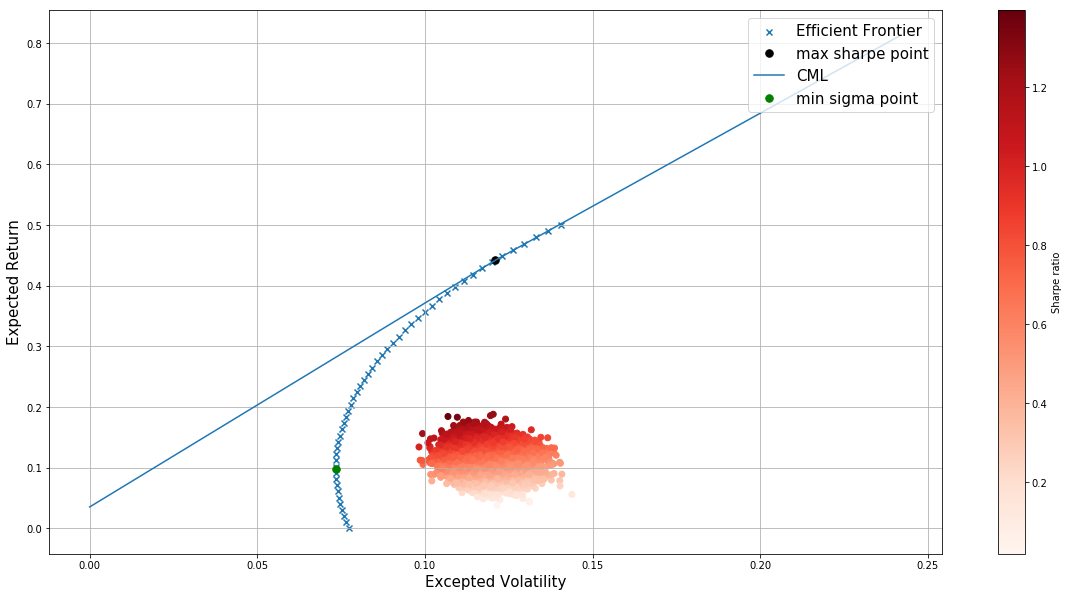

In [17]:
#绘制图形
plt.figure(figsize = (20,10))
plt.scatter(PORT_SIGMAS, PORT_RETURNS, c=PORT_SR, marker = 'o', cmap='Reds')

plt.grid(True)
plt.xlabel('Excepted Volatility',fontsize=15)
plt.ylabel('Expected Return',fontsize=15)
plt.colorbar(label = 'Sharpe ratio')

#叉号代表有效前沿
EFFICIENT_FRONTIER=plt.scatter(FRONTIER_SIGMA_ARRAY, FRONTIER_RETURNS_ARRAY, marker = 'x')
#黑点代表最高sharpe组合
MAX_SHARP_POINT,=plt.plot(get_return_risk(MAX_SHARP['x'],SH50_PRICE_DF,RF)[1], 
                          get_return_risk(MAX_SHARP['x'],SH50_PRICE_DF,RF)[0], 
                          'k.', markersize = 15.0)
#绘制CML
CML,=plt.plot([0,get_return_risk(MAX_SHARP['x'],SH50_PRICE_DF,RF)[1],
               2*get_return_risk(MAX_SHARP['x'],SH50_PRICE_DF,RF)[1]],
              [RF,get_return_risk(MAX_SHARP['x'],SH50_PRICE_DF,RF)[0],
              2*(get_return_risk(MAX_SHARP['x'],SH50_PRICE_DF,RF)[0]-RF)])
#绿点代表最小方差组合
MIN_SIGMA_POINT,=plt.plot(get_return_risk(MIN_SIGMA['x'],SH50_PRICE_DF,RF)[1], 
                          get_return_risk(MIN_SIGMA['x'],SH50_PRICE_DF,RF)[0], 
                          'g.', markersize = 15.0)
        
plt.legend([EFFICIENT_FRONTIER,MAX_SHARP_POINT,CML,MIN_SIGMA_POINT],
           ["Efficient Frontier","max sharpe point","CML","min sigma point"], 
           loc="upper right",fontsize=15)

plt.show()